# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [25]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

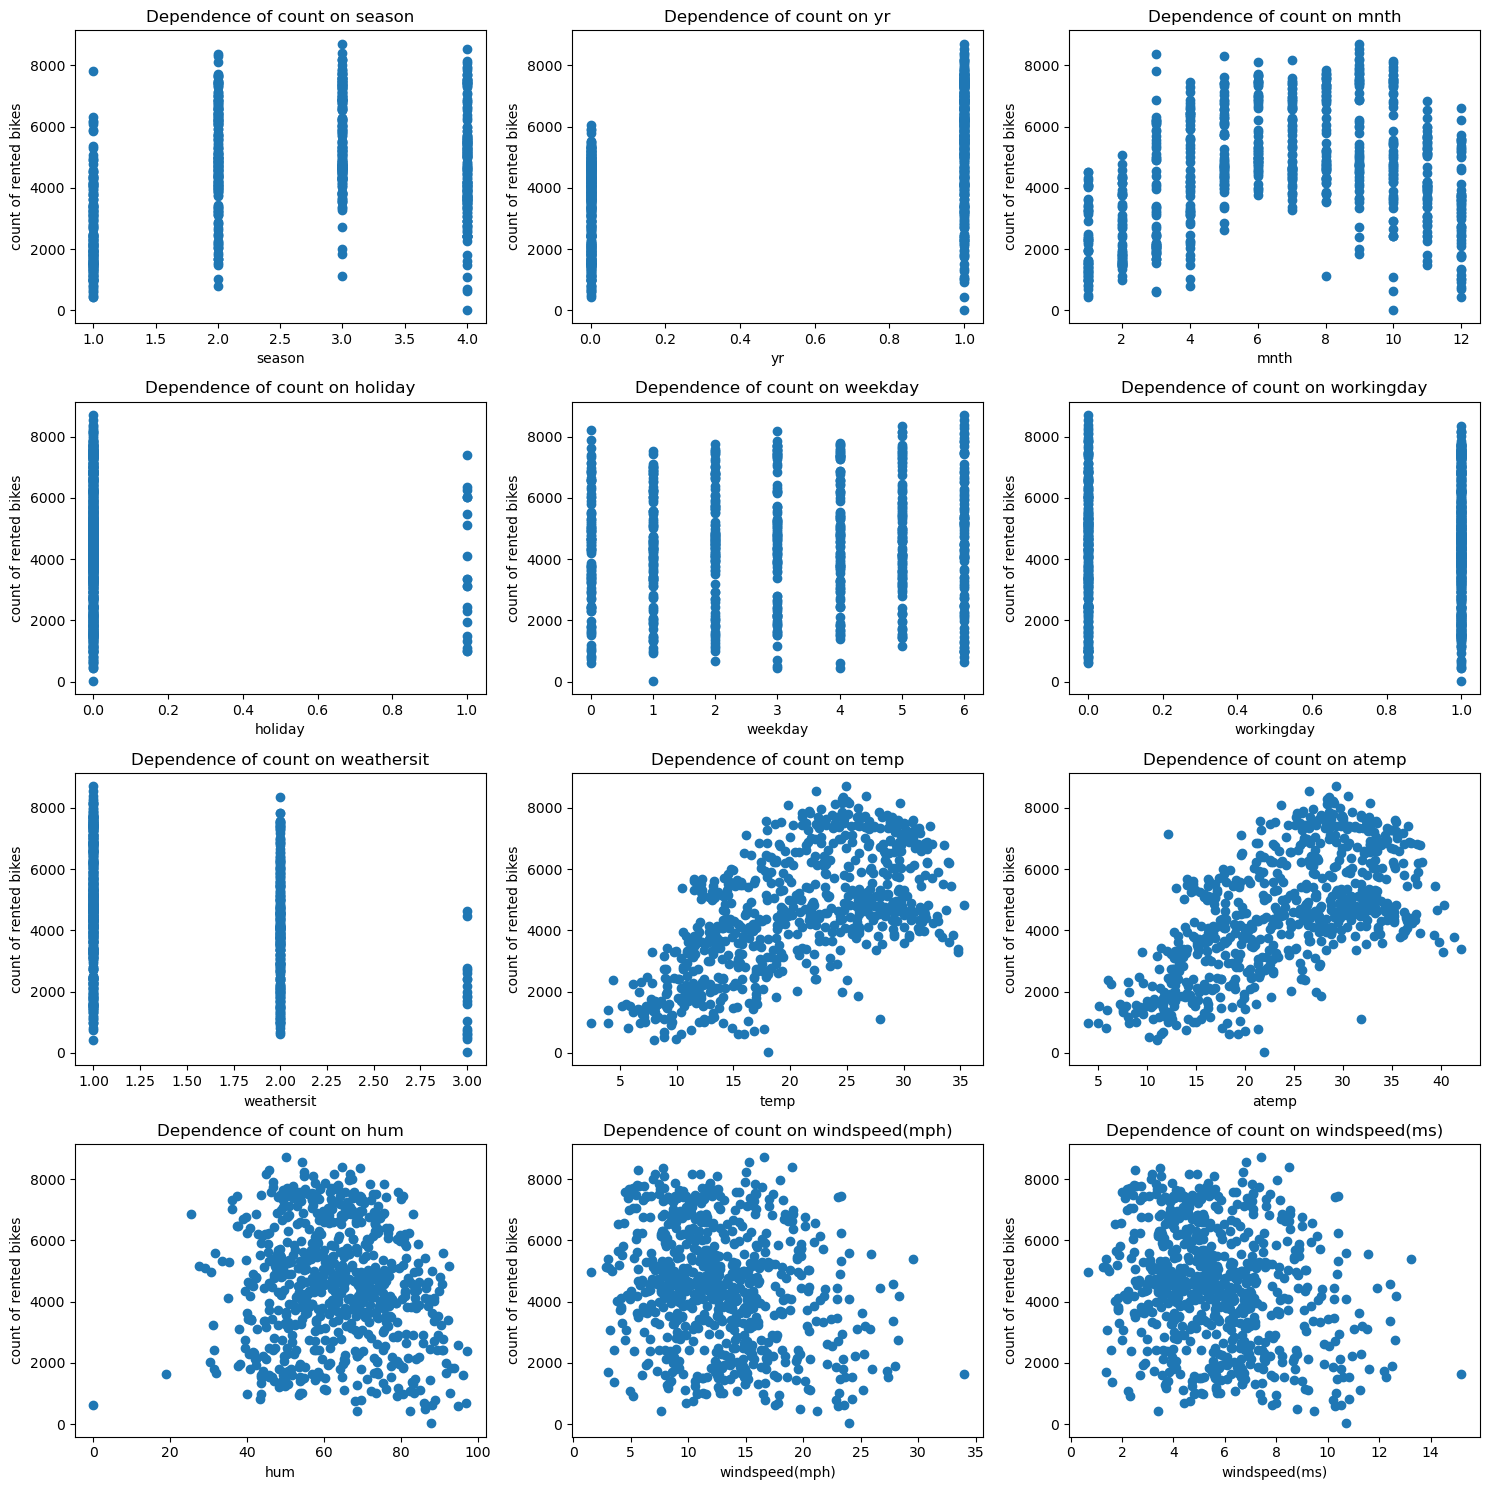

In [3]:
attributes = df.drop(columns=['cnt']).columns.tolist()
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
y = np.array(df['cnt'])
for i in range(len(attributes)):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    X = np.array(df[[attributes[i]]])
    ax.scatter(X, y)
    ax.set_title(f'Dependence of count on {attributes[i]}')
    ax.set_xlabel(f'{attributes[i]}')
    ax.set_ylabel('count of rented bikes')

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
    "__Відповідь:__" У лінтні місяці кількість прокатів збільшується, у зимові місяці зменшується.
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.
    "__Відповідь:__" Кількість прокатів залежить від 'temp' та 'atemp' скоріше за все лінійно.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [4]:
correlations = {}
for attribute in attributes:
    correlation = df[attribute].corr(df['cnt'])
    correlations[attribute] = correlation

# Виведення результатів
for attribute, correlation in correlations.items():
    print(f"Кореляція Пірсона між '{attribute}' та цільовим значенням: {correlation}")

# Обчислення кореляції між цільовою змінною та іншими атрибутами за допомогою методу corrwith
correlation_with_target = df.corrwith(df['cnt'])

# Виведення результатів
print("Кореляція з цільовою змінною:")
print(correlation_with_target)

Кореляція Пірсона між 'season' та цільовим значенням: 0.40610037079863753
Кореляція Пірсона між 'yr' та цільовим значенням: 0.566709707868086
Кореляція Пірсона між 'mnth' та цільовим значенням: 0.27997711221927096
Кореляція Пірсона між 'holiday' та цільовим значенням: -0.06834771589248412
Кореляція Пірсона між 'weekday' та цільовим значенням: 0.06744341241063044
Кореляція Пірсона між 'workingday' та цільовим значенням: 0.06115606306052083
Кореляція Пірсона між 'weathersit' та цільовим значенням: -0.2973912388346635
Кореляція Пірсона між 'temp' та цільовим значенням: 0.6274940090334926
Кореляція Пірсона між 'atemp' та цільовим значенням: 0.6310656998491815
Кореляція Пірсона між 'hum' та цільовим значенням: -0.10065856213715528
Кореляція Пірсона між 'windspeed(mph)' та цільовим значенням: -0.23454499742166998
Кореляція Пірсона між 'windspeed(ms)' та цільовим значенням: -0.23454499742168924
Кореляція з цільовою змінною:
season            0.406100
yr                0.566710
mnth           

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [5]:
# Визначаємо необхідні ознаки для кореляцій
features_for_correlation = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислення кореляцій
correlation_matrix = df[features_for_correlation].corr()

# Виведення результатів
print("Попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та цільовою змінною cnt:")
correlation_matrix

Попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та цільовою змінною cnt:


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

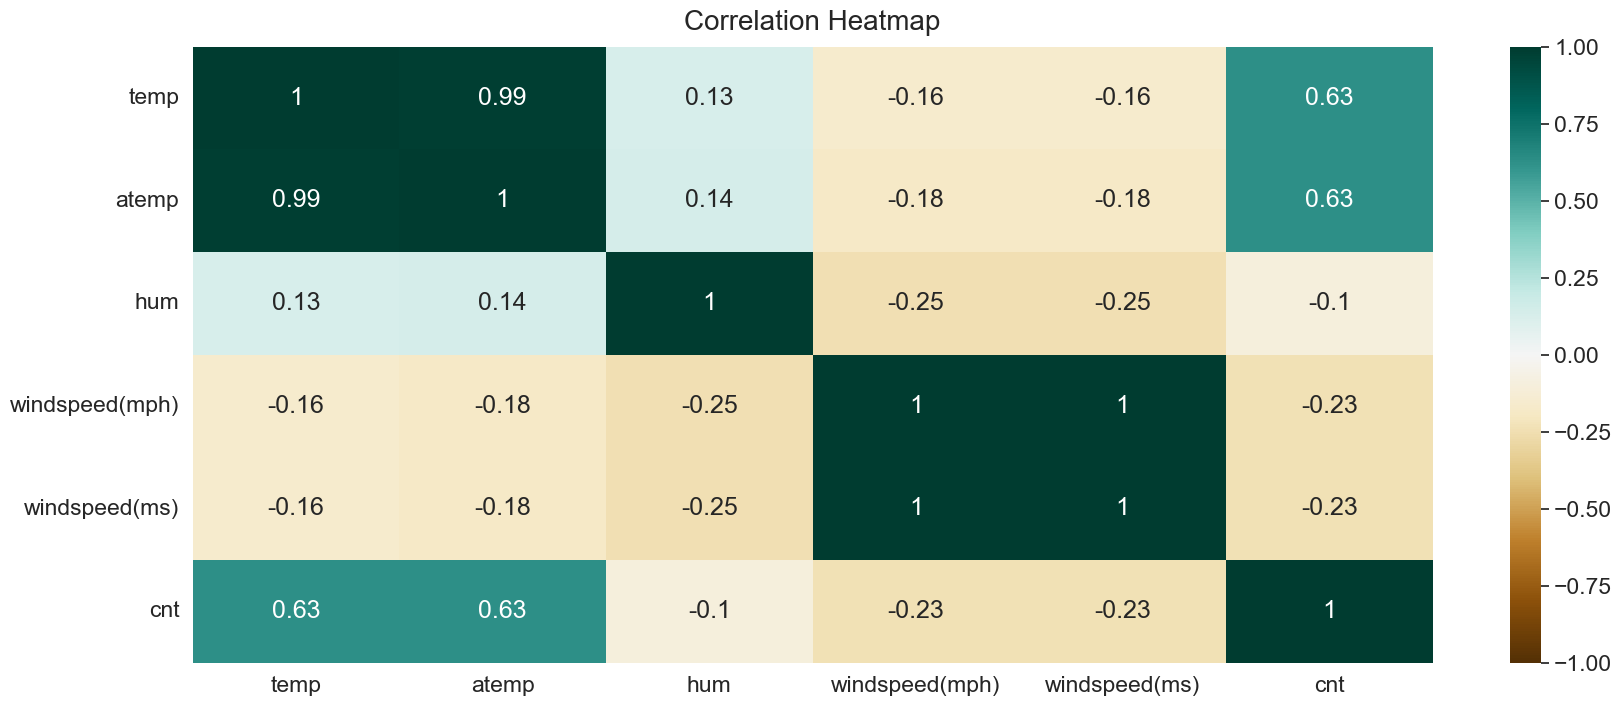

In [6]:
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [7]:
# Знаходимо середні значення по стовпцям
column_means = df.mean()

# Виводимо середні значення
column_means

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [11]:
# Створюємо лінійний регресор
regressor = LinearRegression()

# Навчаємо модель на всіх даних
regressor.fit(X, y)

# Отримуємо ваги моделі
weights = regressor.coef_

# Виводимо пари (назва ознаки, вага)
for feature, weight in zip(df[:-1].columns, weights):
    print(f"{feature}: {weight}")

season: 570.869656136827
yr: 1021.9695854791905
mnth: -141.30369781651
holiday: -86.75568078104659
weekday: 137.2207796246191
workingday: 56.39245384513776
weathersit: -330.2286104374464
temp: 367.4756869937709
atemp: 585.5530733408308
hum: -145.61170288467218
windspeed(mph): 12457605707555.143
windspeed(ms): -12457605707753.6


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [12]:
from sklearn.linear_model import Lasso

# Створюємо модель з регуляризацією Lasso
lasso_model = Lasso()

# Навчаємо модель на всіх даних
lasso_model.fit(X, y)

# Отримуємо ваги моделі
weights = lasso_model.coef_

# Виводимо пари (назва ознаки, вага)
for feature, weight in zip(df[:-1].columns, weights):
    print(f"{feature}: {weight}")

season: 560.2416160308862
yr: 1019.4634940657195
mnth: -128.73062703678715
holiday: -86.15278133371106
weekday: 137.34789390496323
workingday: 55.21237064135662
weathersit: -332.3698569623487
temp: 376.36323620969586
atemp: 576.5307935045538
hum: -144.12915500348592
windspeed(mph): -197.13968940248492
windspeed(ms): -2.8050769963390902e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [13]:
from sklearn.linear_model import Ridge

# Створюємо модель з регуляризацією Ridge
ridge_model = Ridge()

# Навчаємо модель на всіх даних
ridge_model.fit(X, y)

# Отримуємо ваги моделі
weights = ridge_model.coef_

# Виводимо пари (назва ознаки, вага)
for feature, weight in zip(df[:-1].columns, weights):
    print(f"{feature}: {weight}")

season: 563.0645722520193
yr: 1018.9483787875304
mnth: -131.87332028247852
holiday: -86.74609799709215
weekday: 138.00511117871886
workingday: 55.903110375064784
weathersit: -332.3497884990735
temp: 386.45788919195684
atemp: 566.3470470600174
hum: -145.07132729867163
windspeed(mph): -99.25944108181875
windspeed(ms): -99.25944115431494


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)

# Ініціалізуємо списки для збереження ваг
coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    # Навчання моделі Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Навчання моделі Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Конвертуємо списки в np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("Коефіцієнти ваг при регуляції Lasso")
print(coefs_lasso)
print("Коефіцієнти ваг при регуляції Ridge")
print(coefs_ridge)

Коефіцієнти ваг при регуляції Lasso
[[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80507700e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29889803e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41651971e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62785293e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

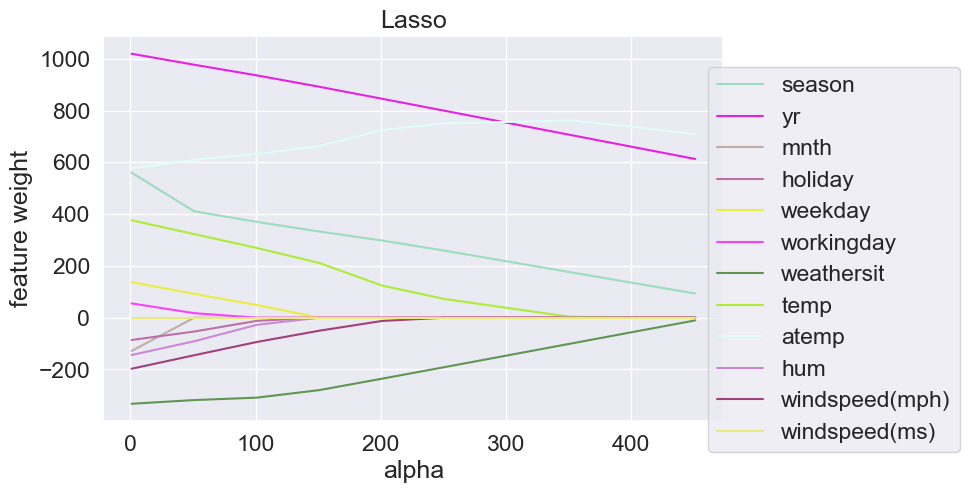

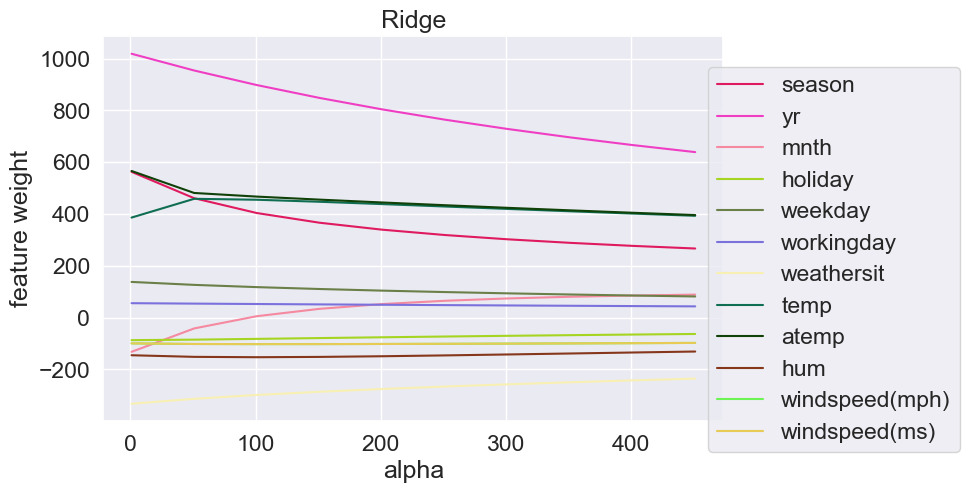

In [15]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
   "__Відповідь:__" Агресивніше зменшує ваги при одному й тому самому alpha регуляризатор Lasso.
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
   "__Відповідь:__" Якщо alpha зробити дуже великим (приблизно 3000), то ваги при регуляції Lasso стануть рівними 0. Так відбувається тому що функція штрафується за величину абсолютного значення коефіцієнтів, а це означає, що збільшення значення параметру alpha призведе до більшого штрафу за великі значення коефіцієнтів.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
   "__Відповідь:__" Так, можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0, бо вже при alpha = 1 значення ваги дуже близько до 0. А Ridge ні, бо навіть при alpha = 450 значення ваги не стає меншим за $10^{-3}$. 
1. Який із регуляризаторів підійде для відбору неінформативних ознак?
   "__Відповідь:__" Для відбору неінформативних ознак підійде регуляризатор Lasso.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [16]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid(color='black')
    plt.show()

Значення alpha з найменшим MSE: 6.0

Ваги моделі для цього alpha:
season: 532.0189828413537
yr: 1015.0602226430597
mnth: -100.03952614356638
holiday: -83.29395987529907
weekday: 132.50446549095793
workingday: 51.55708561407392
weathersit: -330.5598567399813
temp: 370.6798550300334
atemp: 581.3969310654987
hum: -140.00740550068866
windspeed(mph): -191.77140847134925
windspeed(ms): -2.6855907924014633e-08


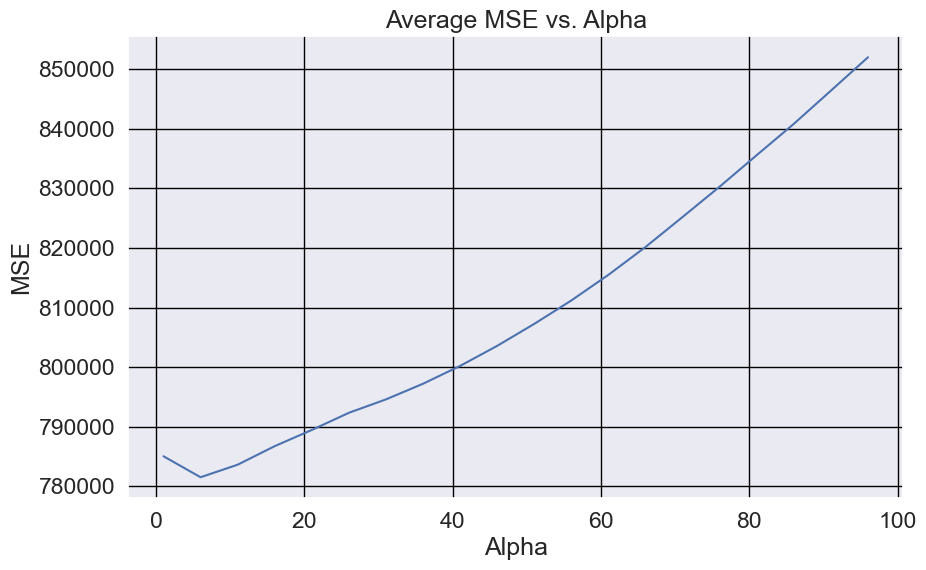

In [18]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3)

# Навчаємо регресор LassoCV та обчислюємо усереднений за рядками MSE
regressor.fit(X, y)
mse_values = np.mean(regressor.mse_path_, axis=1)

# Формуємо дані для графіка
data = np.column_stack((regressor.alphas_, mse_values))

# Знаходження індексу мінімального значення MSE
min_mse_index = np.argmin(mse_values)

# Значення alpha з найменшим MSE
best_alpha = data[min_mse_index, 0]

# Створення моделі Lasso з найкращим параметром alpha
best_model = Lasso(alpha=best_alpha)

# Навчання моделі на всіх даних
best_model.fit(X, y)

# Отримуємо ваги моделі для найкращого alpha
weights_best_model = best_model.coef_

# Виведення результату
print(f"Значення alpha з найменшим MSE: {best_alpha}\n")

# Виводимо пари (назва ознаки, вага)
print("Ваги моделі для цього alpha:")
for feature, weight in zip(df[:-1].columns, weights_best_model):
    print(f"{feature}: {weight}")

# Побудова графіка
create_plot(data, 'Average MSE vs. Alpha', 'Alpha', 'MSE', figsize=(10, 6))

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


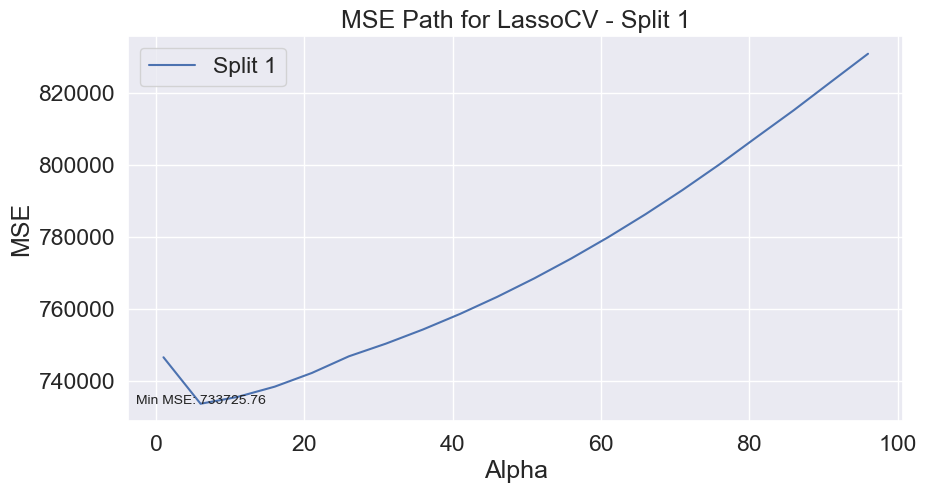

Alpha: 6, Min MSE: 733725.76


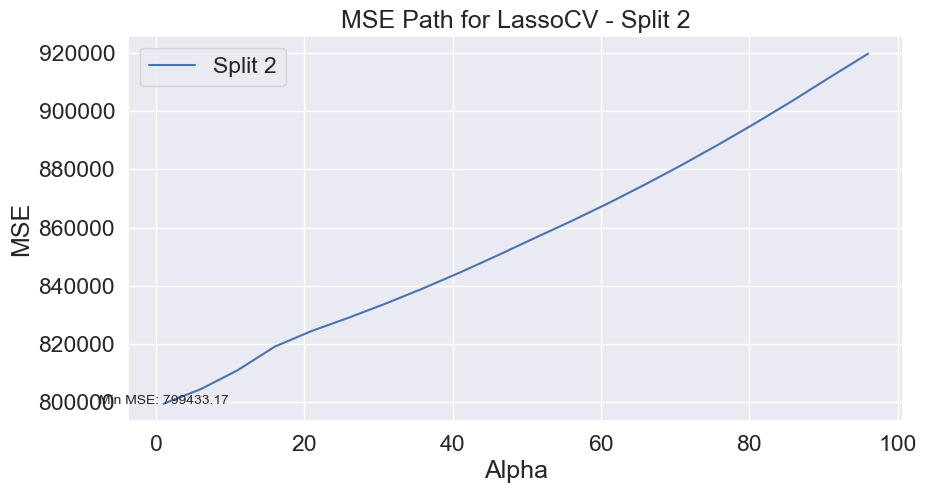

Alpha: 1, Min MSE: 799433.17


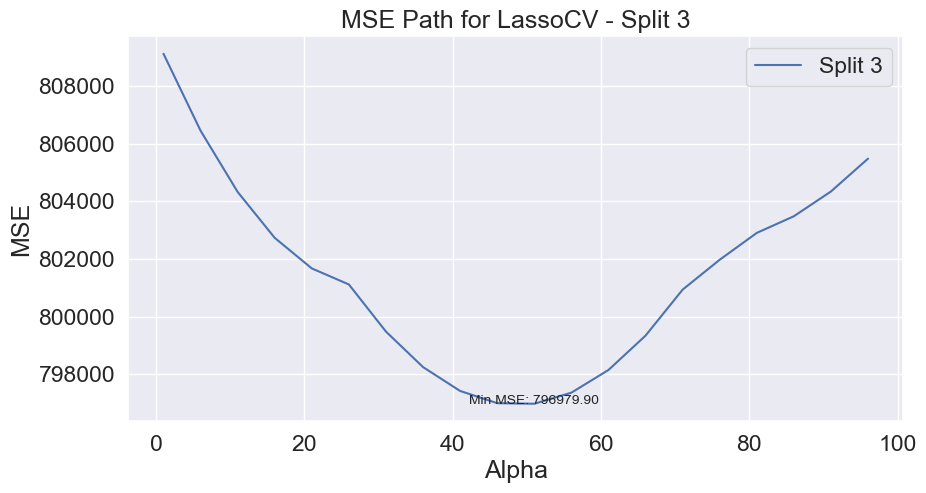

Alpha: 51, Min MSE: 796979.90


In [19]:
# Створення та налаштування графіків
for i in range(regressor.mse_path_.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f'Split {i+1}')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.title(f'MSE Path for LassoCV - Split {i+1}')
    plt.grid(True)
    
    # Визначення мінімального значення MSE та відповідного alpha
    min_mse_index = np.argmin(regressor.mse_path_[:, i])
    min_mse_alpha = regressor.alphas_[min_mse_index]
    min_mse_value = regressor.mse_path_[min_mse_index, i]
   
    # Відображення відповідного мінімального значення MSE на графіку
    plt.text(min_mse_alpha, min_mse_value, f'Min MSE: {min_mse_value:.2f}', fontsize=10, ha='center')
    
    plt.legend()
    plt.show()

    # Виведення alpha та відповідного мінімального значення MSE
    print(f"Alpha: {min_mse_alpha}, Min MSE: {min_mse_value:.2f}")

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [23]:
# Отримуємо індекси відсортованих ваг у порядку зменшення
sorted_indices = np.argsort(weights_best_model)[::-1]
feature_names = df[:-1].columns

# Вибираємо чотири перших позитивних значення
positive_indices = [index for index in sorted_indices if weights_best_model[index] > 0][:4]

# Виводимо ім'я ознаки разом із вагами
for index in positive_indices:
    print(f"{feature_names[index]}: {weights_best_model[index]}")

yr: 1015.0602226430597
atemp: 581.3969310654987
season: 532.0189828413537
temp: 370.6798550300334


4 ознаки з найбільшими (позитивними) коефіцієнтами: __yr__, __atemp__, __season__ та __temp__.
- Відносно ознаки __yr__, то у данних представленно лише 2 значення, це замало для того щоб робити висновок, що рік впливає на кількість оренди велосипедів, по графіку також не можна визначити цю закономірність.
- Відносно ознак __atemp__ та __temp__, то як видно з матриці кореляції, ці дві ознаки дуже сильно корелюють між собою, тому мають однаковий вплив на кількість оренди. А виходячи з графіків, можна стрерджувати, що зі збільшенням температури буде рости і кількість оренди велосипедів, але починаючи з температури повітря 25 градусів помітне зменшення кількості оренди велосипедів із збільшенням температури, це логічно, бо при екстремально високих температурах велопрогулянки некомфортні.
- Відносно ознаки __season__, то так, виходячи з графика помітна тенденція збільшення кількості оренди велосипедів з весни до осені, але на зиму це значення зменшується. Враховуючи, що ця ознака має лише 4 значення, то не логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цієї ознаки, тим більше людей захочуть взяти велосипеди. Ця закономірність не лінійна, а циклічна

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

3 ознаки з найбільшими за модулем негативними коефіцієнтами:
- __weathersit:__ -330.56. Виходячи з візуалізації, помітна залежність, що чим більша величина цієї ознаки, тим менше людей захочуть взяти велосипеди. Але в даних представлено лише 3 значення, і судячи з опису цієї ознаки вона має обмеження
- __windspeed(mph):__ -191.77. Виходячи з візуалізації, помітна залежність, що чим більша величина цієї ознаки, тим менше людей захочуть взяти велосипеди.
- __hum:__ -140.01. Виходячи з візуалізації, цю залежність важко помітити, тому не логічно стверджувати що чим більша величина цієї ознаки, тим менше людей захочуть взяти велосипеди.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

Ознака з коефіцієнтами, близькими до нуля (< 1e-3):
- __windspeed(ms)__: -2.69e-08
Модель виключила цю ознаку із моделі, тому що вона сильно корерює з ознакою __windspeed(mph)__ (це по суті одне й теж саме), а коли ознаки сильно корелюють між собою, Lasso може вибрати одну з них і зменшити до 0

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.